In [2]:
import matplotlib as mpl, pandas as pd, numpy as np, geopandas as gpd, matplotlib.pyplot as plt, pingouin as pin
import pysal as ps, networkx as nx

from math import sqrt
import pylab
import ast

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.precision", 2)
pd.options.display.float_format = '{:20.2f}'.format
from matplotlib.colors import LinearSegmentedColormap

import cityImage as ci
import ABManalysis as af

## 1. Loading Data
#### *Coordinate System of the case study area for cartographic visualisations*

In [3]:
# initialise path, names, etc.
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

In [4]:
input_path = 'Input/empiricalABM/'+city_name
output_path = 'Outputs/empiricalABM/'+city_name

edges = gpd.read_file(input_path+'_edges.shp', driver='ESRI Shapefile')
nodes = gpd.read_file(input_path+'_nodes.shp', driver='ESRI Shapefile')

nodes.index, edges.index = nodes.nodeID, edges.edgeID
nodes.index.name, edges.index.name = None, None

### 1.1 Loading  the simulation's volumes and assigning them to the segments of the street network

In [5]:
summary_clusters = pd.read_csv(output_path+'_clusters.csv', index_col = 0)
clusters = ['group0', 'group1', 'group2', 'group3', 'group4', 'group5']
configurations = ['nullGroup', 'population', 'hetero']
columns = ['edgeID'] + summary_clusters.index.to_list() + ['hetero']
runs = 20

# creating a list of dataframes, one dataframe per each run containing the street segments' volumes
df_list = []
for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_empirical_DMA_'+str(run)+'.csv')
    df_tmp['hetero'] = df_tmp[clusters].sum(axis=1)
    for n, c in enumerate(columns): 
        df_tmp.rename(columns={c: columns[n]+"_"+str(run)}, inplace=True)
    df_list.append(df_tmp)

    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID_0
for run in range(runs): 
    df.drop(['edgeID'+"_"+str(run)], axis = 1, inplace = True)

# creating a list of only 3 dataframes, one per configuration, from the previous list of dataframes
cf_df_list = []
for configuration in configurations: 
    cf_df_list.append(df[[col for col in df if col.startswith(configuration)]+['edgeID']])

In [6]:
print('Example of the null configuration DF')
cf_df_list[0].head()

Example of the null configuration DF


,nullGroup_0,nullGroup_1,nullGroup_2,nullGroup_3,nullGroup_4,nullGroup_5,nullGroup_6,nullGroup_7,nullGroup_8,nullGroup_9,...,nullGroup_11,nullGroup_12,nullGroup_13,nullGroup_14,nullGroup_15,nullGroup_16,nullGroup_17,nullGroup_18,nullGroup_19,edgeID
0,21,21,17,16,13,12,15,21,19,21,...,18,23,16,21,26,21,20,13,20,9
1,10,11,10,16,16,9,7,13,12,14,...,12,9,14,9,15,15,11,15,14,24
2,13,10,10,13,20,13,17,14,11,20,...,12,10,15,8,11,13,15,11,17,32
3,9,9,15,14,12,10,15,12,14,12,...,13,13,17,5,12,11,21,8,19,37
4,21,22,22,21,29,21,24,21,23,16,...,14,25,13,19,18,24,30,23,25,38


### 1.2 Computing the volumes per group/agent typology (Heterogeneous configuration)

In [7]:
# repeating the procedure but only considering the heterogeneous configuration, and differentiate the volumes by cluster
columns = ['edgeID'] + clusters
runs = 20

# creating a list of dataframes, one dataframe per each run containing the street segments' volumes
df_list_clusters = []
for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_empirical_DMA_'+str(run)+'.csv')
    for n, c in enumerate(columns): 
        df_tmp.rename(columns={c: columns[n]+"_"+str(run)}, inplace=True)
    df_list_clusters.append(df_tmp)
    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID_0
for run in range(runs): 
    df.drop(['edgeID'+"_"+str(run)], axis = 1, inplace = True)

# creating a list of only 3 dataframes, one per configuration, from the previous list of dataframes
cf_df_list_clusters = []
for cluster in clusters: 
    cf_df_list_clusters.append(df[[col for col in df if col.startswith(cluster)]+['edgeID']])

In [8]:
# aggregate the runs' values
edges = af.aggregate_runs(cf_df_list, configurations, edges, ddof = 0)
edges = af.aggregate_runs(cf_df_list_clusters, clusters, edges, ddof = 0)

### 1.3 Computing *p_values* to assess to what extent the homogeneous and heterogeneous configurations produce different results from the null configuration

In [9]:
# getting again the volumes from each run
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID_0
for run in range(runs): 
    df.drop(['edgeID'+"_"+str(run)], axis = 1, inplace = True)

In [10]:
labels = ['null', 'homogeneous', 'heterogeneous']
edges_list = list(edges['edgeID'])

# creating a list of dataframes. Each dataframe represents a street segment. It contains the volumes of each run, 
# per each configuration
df_edges = []
for edge in edges_list:
    df_tmp = pd.DataFrame(columns=['value','configuration'])
    
    for n, df in enumerate(df_list):
        df = df.copy()
        df.index = df['edgeID_'+str(n)]
        row = df.loc[edge]
        values = [row['nullGroup_'+str(n)], row['population_'+str(n)], row['hetero_'+str(n)]]
        for nn, value in enumerate(values):  
            df_tmp.loc[-1] = [value, labels[nn]]
            df_tmp.index = df_tmp.index + 1
            
    df_tmp['value'] = df_tmp['value'].astype(int)
    df_edges.append(df_tmp)

In [11]:
print("Example of a street segment's df (3 configurations x 20 runs = 60 values)")
df_edges[0].head()

Example of a street segment's df (3 configurations x 20 runs = 60 values)


,value,configuration
59,21,null
58,18,homogeneous
57,14,heterogeneous
56,21,null
55,21,homogeneous


In [12]:
edges['hetero_pvalue'] = 0.000
edges['homo_pvalue'] = 0.000
edges['homo_pvalue_cl'] = "No significant diff."
edges['hetero_pvalue_cl'] = "No significant diff."

# performing wilcoxon test per each edge and 
for n, df_edge in enumerate(df_edges):
    x = df_edge[df_edge['configuration'] == 'null']['value'].to_list()
    y = df_edge[df_edge['configuration'] == 'heterogeneous']['value'].to_list()
    z = df_edge[df_edge['configuration'] == 'homogeneous']['value'].to_list()

    # null vs heterogeneous
    if x != y:
        hetero = pin.wilcoxon(x = x, y = y, alternative='two-sided')
        hetero_pvalue = hetero.iloc[0]['p-val']
    else:
        hetero_pvalue = 1.0
    
    # null vs homogeneous
    if x != z:
        homo = pin.wilcoxon(x = x, y = z, alternative='two-sided')
        homo_pvalue = homo.iloc[0]['p-val']
    else:
        homo_pvalue = 1.0
    
    # assigning the result to the edges gdf
    edge = edges_list[n]
    edges.at[edge, 'hetero_pvalue'] = hetero_pvalue
    edges.at[edge, 'homo_pvalue'] = homo_pvalue
    
    if edges.loc[edge]['hetero_pvalue'] <= 0.05:
        if edges.loc[edge]['hetero'] > edges.loc[edge]['nullGroup']:
            color_hetero = "Significant diff. (+)"
        else:
            color_hetero = "Significant diff. (-)"
        edges.at[edge, 'hetero_pvalue_cl'] = color_hetero
            
    if edges.loc[edge]['homo_pvalue'] <= 0.05:
        if edges.loc[edge]['population'] > edges.loc[edge]['nullGroup']:
            color_homo = "Significant diff. (+)"      
        else:
            color_homo = "Significant diff. (-)"
        edges.at[edge, 'homo_pvalue_cl'] = color_homo

In [23]:
edgestt = edges.set_crs(crs, allow_override=True).copy()

In [26]:
edgestt.bounds

,minx,miny,maxx,maxy
9,405012.06,5756493.40,405105.91,5756664.15
24,405558.93,5757005.74,405615.29,5757015.46
32,405615.29,5757015.46,405670.20,5757017.44
37,405583.36,5757015.46,405615.29,5757062.70
38,405701.07,5756902.54,405767.23,5756939.60
...,...,...,...,...
30338,405589.71,5759908.38,405599.03,5759917.76
14590,405929.27,5756157.25,405970.20,5756367.36
15234,406284.12,5757595.53,406305.73,5757672.78
30300,406179.36,5757693.14,406185.16,5757836.98


In [27]:
crs

'EPSG:25832'

In [22]:
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

In [24]:
## Saving volumes
edgestt.to_file(output_path+'_pedSim_empiricaltts.shp', use_unicode=True, driver='ESRI Shapefile')

CRSError: Invalid input to create CRS: PROJCRS["ETRS89 / UTM zone 32N",BASEGEOGCRS["ETRS89",ENSEMBLE["European Terrestrial Reference System 1989 ensemble",MEMBER["European Terrestrial Reference Frame 1989"],MEMBER["European Terrestrial Reference Frame 1990"],MEMBER["European Terrestrial Reference Frame 1991"],MEMBER["European Terrestrial Reference Frame 1992"],MEMBER["European Terrestrial Reference Frame 1993"],MEMBER["European Terrestrial Reference Frame 1994"],MEMBER["European Terrestrial Reference Frame 1996"],MEMBER["European Terrestrial Reference Frame 1997"],MEMBER["European Terrestrial Reference Frame 2000"],MEMBER["European Terrestrial Reference Frame 2005"],MEMBER["European Terrestrial Reference Frame 2014"],ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[0.1]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["UTM zone 32N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",9,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",500000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1]],USAGE[SCOPE["Engineering survey, topographic mapping."],AREA["Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore."],BBOX[38.76,6,84.33,12]],ID["EPSG",25832]]

### 1.2 Loading the simulation's individual routes

In [111]:
## reloading routes if already processed
routes_gdfs = []
for n, configuration in enumerate(configurations):
    routes_gdf = gpd.read_file(output_path+'_'+configuration+'_routes.shp', driver='ESRI Shapefile')
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdfs.append(routes_gdf)

In [84]:
# or processing them from the simulation output
input_path_routes = 'Input/empiricalABM/routes/'+city_name
routes_gdfs = []

for run in range(runs):
    run_gdf = gpd.read_file(input_path_routes+'_PedSim_empirical_DMA_'+str(run)+'.shp')
    run_gdf.set_crs(crs)
    
    for n, configuration in enumerate(configurations):
        if configuration == 'hetero':
            configuration_gdf = run_gdf[run_gdf.group.isin(clusters)].copy()
        else:
            configuration_gdf = run_gdf[run_gdf.group == configuration].copy()
        if run == 0:
            routes_gdf = configuration_gdf.copy()
            routes_gdfs.append(configuration_gdf)
            continue
        
        routes_gdf = routes_gdfs[n].copy()
        routes_gdf = routes_gdf.append(configuration_gdf)
        routes_gdf.reset_index(inplace = True, drop=True)
        routes_gdf = routes_gdf.where(pd.notnull(routes_gdf), None)
        routes_gdf.replace({"None":None}, inplace = True)
        routes_gdfs[n] = routes_gdf

In [85]:
# preparing the routes gdf
for n, configuration in enumerate(configurations): 
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdf['O'] = routes_gdf['O'].astype(int)
    routes_gdf['D'] = routes_gdf['D'].astype(int)
    routes_gdfs[n] = routes_gdf

## 2. Route statistics
### 2.1 Deviation from the road-distance shortest path

In [86]:
## computing the deviation from the road-distance shortest path

graph = ci.graph_fromGDF(nodes, edges, nodeID = "nodeID")
distances = {}
routes_gdf = routes_gdfs[0].copy()
for routes_gdf in routes_gdfs:
    for row in routes_gdf.itertuples():
        source = routes_gdf.loc[row[0]]['O']
        target = routes_gdf.loc[row[0]]['D']
        if str(source)+"-"+str(target) in distances:
            continue
        
        distance = nx.shortest_path_length(graph, source=source, target=target, weight='length', method='dijkstra')
        distances[str(source)+"-"+str(target)] = distance

#### Basic route statistics per configuration

In [94]:
labels = ['null', 'homogeneous', 'heterogeneous']
for n, configuration in enumerate(configurations):

    routes_gdf = routes_gdfs[n].copy()
    print()
    print("Within the", labels[n], "configuration:")
    print("median routes' lenght:", round(routes_gdf.geometry.length.median(),3))
    print("mean routes' lenght:", round(routes_gdf.geometry.length.mean(),3))
    routes_gdf['sp_dist'] = routes_gdf.apply(lambda row: distances[str(row['O'])+"-"+str(row['D'])], axis = 1)
    routes_gdf['sp_dev'] = routes_gdf.geometry.length/routes_gdf['sp_dist']
    print("median routes' deviation from SP", round(routes_gdf['sp_dev'].median(),3))
    routes_gdfs[n] = routes_gdf


Within the null configuration:
median routes' lenght: 2477.92
mean routes' lenght: 2658.513
median routes' deviation from SP 1.132

Within the homogeneous configuration:
median routes' lenght: 2523.551
mean routes' lenght: 2700.419
median routes' deviation from SP 1.182

Within the heterogeneous configuration:
median routes' lenght: 2527.17
mean routes' lenght: 2682.444
median routes' deviation from SP 1.18


#### Basic route statistics per group

In [99]:
for cluster in list(clusters):
    tmp = routes_gdf[routes_gdf.group == cluster].copy()
    print()
    print("Within", cluster+":")
    print("median routes' lenght:", round(tmp.geometry.length.median(),3))
    print("mean routes' lenght:", round(tmp.geometry.length.mean(),3))
    tmp['sp_dist'] = tmp.apply(lambda row: distances[str(row['O'])+"-"+str(row['D'])], axis = 1)
    tmp['sp_dev'] = tmp.geometry.length/tmp['sp_dist']
    print("median routes' deviation from SP", round(tmp['sp_dev'].median(),3))


Within group0:
median routes' lenght: 2543.53
mean routes' lenght: 2637.659
median routes' deviation from SP 1.204

Within group1:
median routes' lenght: 2542.783
mean routes' lenght: 2718.702
median routes' deviation from SP 1.194

Within group2:
median routes' lenght: 2612.126
mean routes' lenght: 2777.266
median routes' deviation from SP 1.164

Within group3:
median routes' lenght: 2464.947
mean routes' lenght: 2626.425
median routes' deviation from SP 1.156

Within group4:
median routes' lenght: 2453.632
mean routes' lenght: 2534.721
median routes' deviation from SP 1.154

Within group5:
median routes' lenght: 2505.575
mean routes' lenght: 2665.691
median routes' deviation from SP 1.201


### 2.2 Elements usage

#### Elements usage per configuration

In [100]:
variables = ['barrier', 'routeMark', 'regions', 'distant']

for n, configuration in enumerate(configurations):
    print()
    print("Within the", labels[n], "configuration:")
    for variable in variables:
        l = len(routes_gdfs[n])
        print(variable, str(round(len(routes_gdfs[n][(routes_gdfs[n][variable] == 1)])/l*100,2))+"%")
    
    routes_gdfs[n]["using"] = routes_gdfs[n].barrier +routes_gdfs[n].routeMark + routes_gdfs[n].regions + routes_gdfs[n].distant
    print("using elements", str(round(len(routes_gdfs[n][(routes_gdfs[n]["using"] > 0)])/l*100,2))+"%")
    print("severing", round(routes_gdfs[n].severing.mean(),3))
    print("natural",  round(routes_gdfs[n].natural.mean(),3))


Within the null configuration:
barrier 18.17%
routeMark 18.6%
regions 23.55%
distant 27.14%
using elements 49.53%
severing 1.503
natural 0.501

Within the homogeneous configuration:
barrier 20.49%
routeMark 20.75%
regions 19.36%
distant 28.87%
using elements 62.57%
severing 1.537
natural 0.509

Within the heterogeneous configuration:
barrier 20.03%
routeMark 21.33%
regions 19.36%
distant 28.48%
using elements 62.47%
severing 1.538
natural 0.509


#### Elements usage per group

In [110]:
for cluster in clusters:
    print()
    print("Within", cluster+":")
    tmp = routes_gdfs[2][routes_gdfs[2].group == cluster].copy()
    l = len(tmp)
    for variable in variables:
        print(variable, str(round(len(tmp[tmp[variable] == 1])/l*100,2)) +"%")
    
    tmp["using"] = tmp.barrier +tmp.routeMark + tmp.regions + tmp.distant
    print("using elements", str(round(len(tmp[tmp["using"] > 0])/l*100,2))+"%")
    print("severing", round(tmp.severing.mean(),3))
    print("natural",  round(tmp.natural.mean(),3))



Within group0:
barrier 21.32%
routeMark 32.03%
regions 20.82%
distant 16.7%
using elements 67.31%
severing 1.517
natural 0.54

Within group1:
barrier 28.4%
routeMark 15.26%
regions 20.04%
distant 34.08%
using elements 66.45%
severing 1.52
natural 0.496

Within group2:
barrier 20.91%
routeMark 12.74%
regions 14.11%
distant 34.37%
using elements 57.11%
severing 1.46
natural 0.496

Within group3:
barrier 13.16%
routeMark 22.14%
regions 25.61%
distant 29.49%
using elements 61.66%
severing 1.642
natural 0.5

Within group4:
barrier 7.3%
routeMark 37.7%
regions 23.17%
distant 12.06%
using elements 60.08%
severing 1.5
natural 0.565

Within group5:
barrier 16.92%
routeMark 29.87%
regions 11.7%
distant 22.99%
using elements 60.22%
severing 1.557
natural 0.524


In [106]:
# export the routes
for n, configuration in enumerate(configurations):
    routes_gdfs[n].drop(['edgeIDs'], axis = 1, errors = 'ignore').to_file(
        output_path+'_'+configuration+'_routes.shp', driver='ESRI Shapefile')

## 3. Volumes

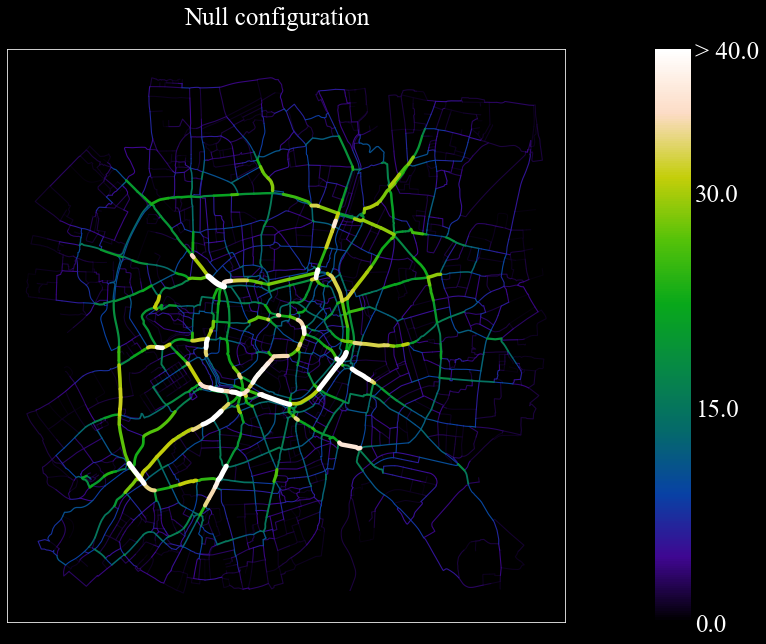

In [175]:
subtitles = ['Null configuration']
norm = mpl.colors.Normalize(vmin = 0, vmax = 40)
fig = ci.plot_gdf(edges, column = configurations[0], cmap = ci.kindlmann(), norm = norm, title = subtitles[0], fig_size = 10,
                       legend = False, cbar = True, cbar_ticks = 3, cbar_max_symbol = True, lw_factor = 0.12, axes_frame = True)

In [176]:
fig.savefig("Outputs/Figures/empiricalABM/f6.pdf", bbox_inches='tight')

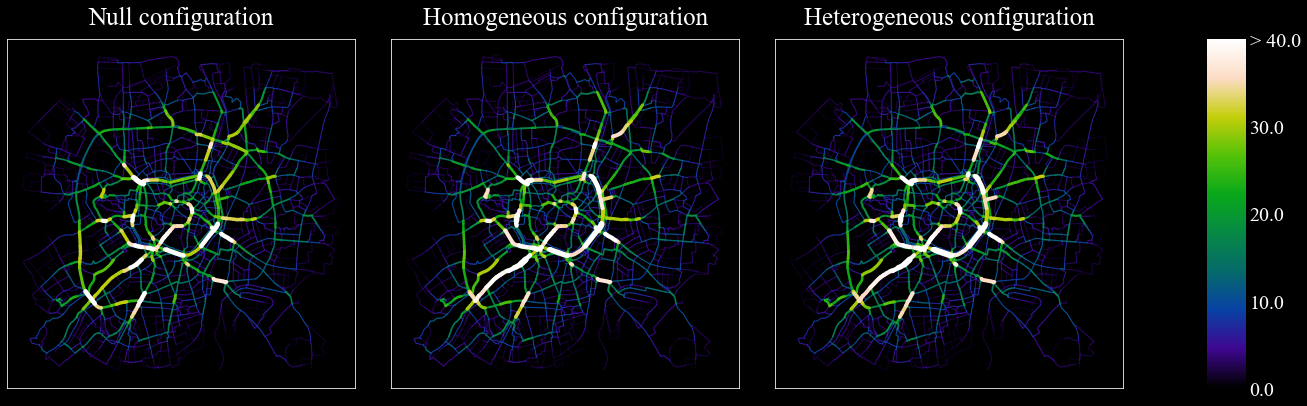

In [120]:
subtitles = [ 'Null configuration', 'Homogeneous configuration', 'Heterogeneous configuration',]
cols = ['null', 'homo', 'hetero']
norm = mpl.colors.Normalize(vmin = 0, vmax = 40)

fig = ci.plot_gdf_grid(edges, ncols = 3, fig_size = 20, columns = configurations, cmap = ci.kindlmann(), titles = subtitles, 
                    norm = norm, legend = False, cbar = True, cbar_ticks = 4, cbar_max_symbol = True, lw_factor = 0.11, 
                    axes_frame = True,  black_background = True)

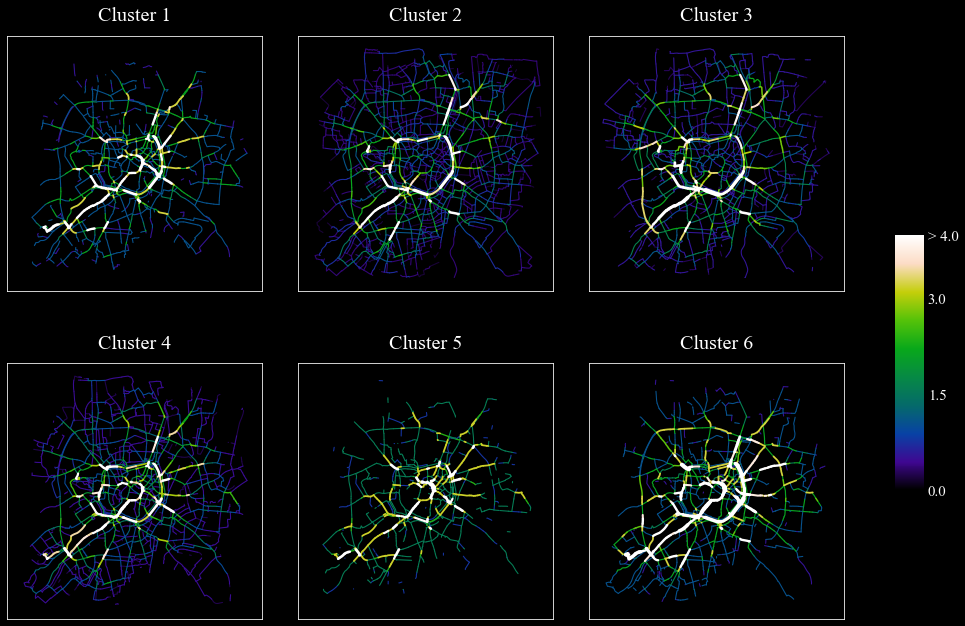

In [173]:
for cluster in clusters:
    edges[cluster+"_%"] = edges[cluster]/(301*summary_clusters.loc[cluster].portion*3)*100

columns = [cluster+"_%" for cluster in clusters]
titles = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5', 'Cluster 6']

norm = mpl.colors.Normalize(vmin = 0, vmax = 4)
fig = ci.plot_gdf_grid(edges, ncols = 3, fig_size = 15, columns = columns, titles = titles, cmap = ci.kindlmann(), 
                    norm = norm, legend = False, cbar = True, cbar_ticks = 3, cbar_max_symbol = True, lw_factor = 0.55, 
                    axes_frame = True,  black_background = True)

In [174]:
fig.savefig("Outputs/Figures/empiricalABM/f8.pdf", bbox_inches='tight')

## 3.1 Differences between configurations

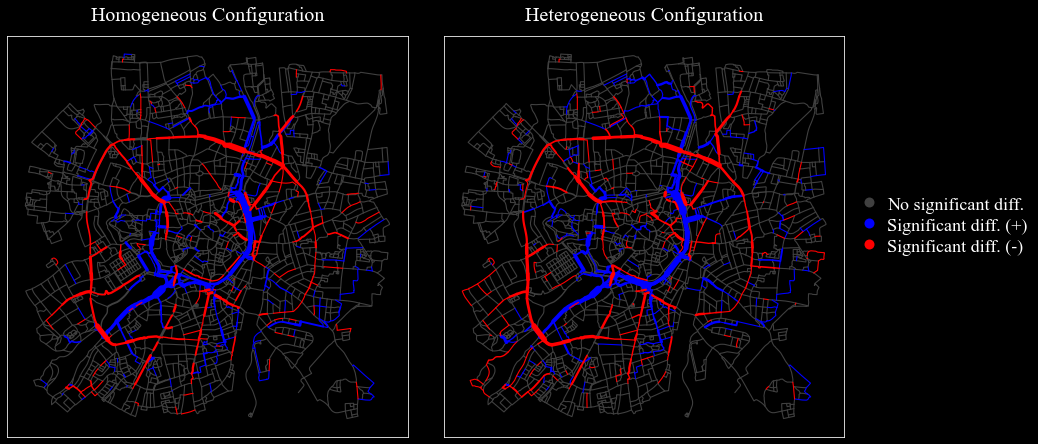

In [171]:
# building the colormap
black_l = ci.lighten_color('black', 0.75)
black_c = ci.lighten_color('grey', 1.00)
red_l = ci.lighten_color('red', 0.40)
blue_l = ci.lighten_color('yellow', 0.40)
cmap = LinearSegmentedColormap.from_list('BkR',['red', red_l, black_l,black_c, black_l, blue_l, 'blue',])

subtitles = ['Homogeneous Configuration', 'Heterogeneous Configuration']
edges['homo_diff'] = abs(edges['population'] - edges['nullGroup'])
edges['hetero_diff'] = abs(edges['hetero'] - edges['nullGroup'])

lw_columns = ['homo_diff', 'hetero_diff'] ## regulating line width
columns = ['homo_pvalue_cl', 'hetero_pvalue_cl']

cmap = LinearSegmentedColormap.from_list('custom_cmap', list_colors)
fig = ci.plot_gdf_grid(edges, columns = columns, classes = 5, cmap = cmap, titles = subtitles, legend = True, 
                    axes_frame = True, scheme = None, lw_columns = lw_columns, lw_factor = 0.55, black_background = True)

In [172]:
fig.savefig("Outputs/Figures/empiricalABM/f7.pdf", bbox_inches='tight')

## 3.2 Configuration volumes' statistics

In [170]:
subtitles = [ 'Null configuration', 'Homogeneous configuration', 'Heterogeneous configuration',]

for n, configuration in enumerate(configurations):
    print()
    print(subtitles[n])
    print('mean is', round(edges[configuration].mean(),2))
    print('STD is', round(edges[configuration].std(),2))
    print('max is', round(edges[configuration].max(),2))
    sg = ps.explore.inequality.gini.Gini(list(edges[configuration]))
    print('Gini coefficient is', round(sg.g,2))


Null configuration
mean is 6.6
STD is 7.76
max is 48.5
Gini coefficient is 0.58

Homogeneous configuration
mean is 6.77
STD is 7.99
max is 56.5
Gini coefficient is 0.57

Heterogeneous configuration
mean is 6.75
STD is 8.01
max is 55.0
Gini coefficient is 0.57
